In [1]:
import sys

import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from batch_gen import SixNumbersBatch
from net import SixHeadedInception
sys.path.append('../..')
import utils
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST
from dataset.models.tf import Inception_v4

In [2]:
dset = MNIST(batch_class=SixNumbersBatch)

ExtractingExtracting  ExtractingExtracting/tmp/train-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz  

/tmp/t10k-images-idx3-ubyte.gz/tmp/t10k-labels-idx1-ubyte.gz



In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .gluing_of_images())
#        .colorize_images(colors=[[0., 0., 1.], [0., 1., 0.]]))

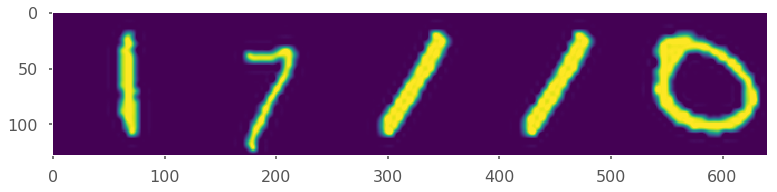

In [4]:
p = (ppl<<dset.train).next_batch(14)
plt.imshow(p.images[0].reshape(128, 640))
plt.grid()

In [5]:
inputs_config = {'images': {'shape':(128, 640, 1)},
                 'labels':{'shape':(5)},#, 'transform': 'ohe', 'name':'targets'},
                 'fir':{'classes':(10), 'transform': 'ohe', 'name':'first'},
                 's':{'classes':(10), 'transform': 'ohe', 'name':'second'},
                 't':{'classes':(10), 'transform': 'ohe', 'name':'third'},
                 'f':{'classes':(10), 'transform': 'ohe', 'name':'fourth'}, 
                 'fi':{'classes':(10), 'transform': 'ohe', 'name':'fifth'}}

config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images'}

four_headed_dict = {'images': B('images'),
                    'labels': B('labels'),
                    'fir': B('first'),
                    's': B('second'),
                    't': B('third'),
                    'f': B('fourth'),
                    'fi': B('fifth')}

In [6]:
four_train_ppl = ((ppl<<dset.train)
                    .init_variable('loss', init_on_each_run=list)
                    .init_model('dynamic',
                                SixHeadedInception,
                                'fourinception',
                                config=config)
                   .train_model('fourinception',
                                fetches='loss',
                                feed_dict=four_headed_dict,
                                save_to=V('loss'), mode='a'))


../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)


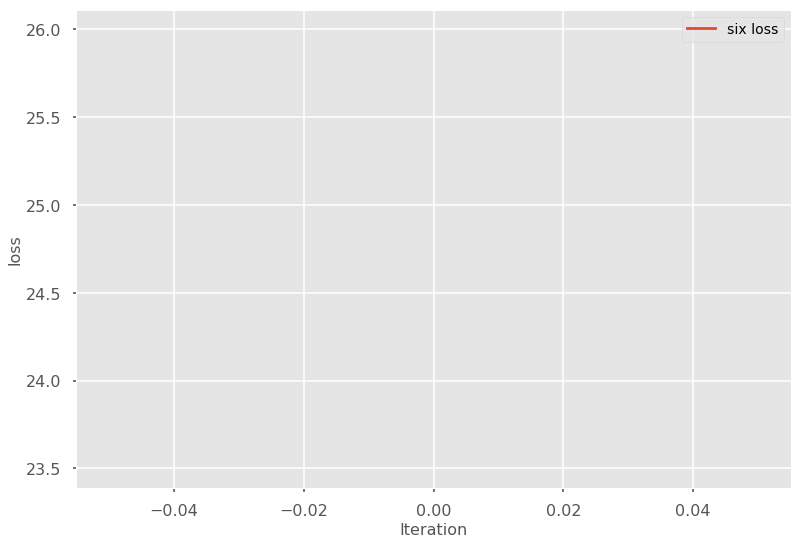

In [7]:
for i in tqn(range(2000)):
    four_train_ppl.next_batch(12)
    if i%10==0:
        clear_output(True)
        utils.draw(four_train_ppl.get_variable('loss'), 'six')
        plt.show()

In [34]:
four_test_ppl = ((ppl<<dset.test)
                    .init_variable('output', init_on_each_run=list)
                    .import_model('fourinception', four_train_ppl)
                    .predict_model('fourinception',
                                  fetches='SixHeadedInception/output:0',
                                  feed_dict=four_headed_dict,
                                  save_to=V('output'), mode='a'))

In [46]:
numbers_true = []
images = []
for i in tqn(range(1)):
    batch = four_test_ppl.next_batch(10, n_epochs=None, suffle=True)
    real = np.array([batch.first, batch.second, batch.third, batch.fourth, batch.fifth])
    print(real)
    images.append(batch.images)
    if len(numbers_true) != 0: 
        numbers_true = np.vstack((numbers_true, np.hstack(real)))
    else:
        numbers_true = np.vstack(real)

    pred = four_test_ppl.get_variable('output')
    predict = np.argmax(np.array(pred).reshape(-1, 5, 10), axis=-1)
numbers_true = numbers_true.T

[[4 0 8 8 8 8 2 3 5 0]
 [5 8 8 8 0 8 5 5 4 0]
 [2 8 5 0 8 8 8 0 8 8]
 [5 8 8 0 0 8 2 8 8 3]
 [0 5 2 2 3 0 2 8 4 0]]



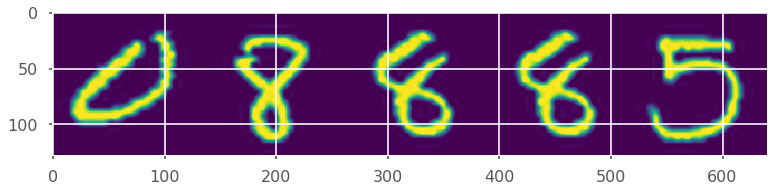

In [47]:
plt.imshow(np.array(images)[0][1].reshape(-1, 640))